In [1]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd

from entities.graphs.data_reader import read_record
from entities.graphs.graph_builder import RawAndPearson, MomentsAndPearson

In [2]:
PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED"
INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_WINDOWED/data.csv"

In [3]:
hyperparams = {
    "batch_size": 64,
    "lr": 0.1,
    "momentum": 0.9,
    "epochs": 100
}

In [4]:
from sklearn.model_selection import train_test_split

# Removing MCI patients to retrieve only HC and AD subjects for binary classification
indices = pd.read_csv(INDEX_PATH, index_col="Unnamed: 0")
indices = indices.drop(indices[indices.label == "MCI"].index)
indices_hc = indices[indices.label == 'HC'].sample(frac=0.4)
indices_ad = indices[indices.label == 'AD']
indices = pd.concat([indices_hc, indices_ad])

train_data, test_data = train_test_split(indices, shuffle=True)

In [5]:

class EEGDataset(Dataset):
    def __init__(self, indices, builder, transform=None):
        self.index_df = indices
        self.transform = transform
        self.builder = builder
        
    def __len__(self):
        return len(self.index_df)
    
    def __getitem__(self, idx):
        current_path = self.index_df.iloc[idx]["path"]
        raw_data = read_record(current_path)
        label = self.index_df.iloc[idx]["label"]
        data = self.builder.build(raw_data, label)
        sample = {
            "x": data.x,
            "edge_attr": data.edge_attr,
            "edge_index": data.edge_index,
            "label": data.label
        }
        return sample

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor()]
) 

builder = MomentsAndPearson()
train_dataset = EEGDataset(train_data, builder, transform=transform)
test_dataset = EEGDataset(test_data, builder, transform=transform)

In [7]:
for i, sample in enumerate(train_dataset):
    print(f"Element {i}: Nodes: {sample['x'].size()}, Edge attributes: {sample['edge_attr'].size()}, Label: {sample['label']}")
    if i == 10: break

Element 0: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 0
Element 1: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 0
Element 2: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 0
Element 3: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 0
Element 4: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 1
Element 5: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 0
Element 6: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 1
Element 7: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 0
Element 8: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 0
Element 9: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 1
Element 10: Nodes: torch.Size([19, 6]), Edge attributes: torch.Size([19, 19]), Label: 1


In [5]:
import torch
from itertools import product
from torch import nn
from torch_geometric.nn import GCNConv, ChebConv, GATConv, GATv2Conv, TransformerConv, global_add_pool
from torch_geometric.data import Data


transformer = TransformerConv(6, 32, heads=2)
gatconv = GATv2Conv(6, 32, heads=2)
attention = nn.MultiheadAttention(1280, num_heads=2, batch_first=True)
conv1 = nn.Conv2d(19, 1, kernel_size=1)
pool = nn.AvgPool2d(3)


input = torch.rand(128, 19, 1280)
weights = torch.rand(19, 19)
edge_index = torch.tensor([[a, b] for a, b in product(range(19), range(19))]).t().contiguous()
#graph = Data(x=input, edge_index=edge_index)
print(f"Input tensor: {input.size()}")

#output = transformer(input, edge_index)
#print(f"Output GATConv: {output.size()}")

output, weights = attention(key=input, value=input, query=input, average_attn_weights=False)
print(f"Output Attention: {output.size()}")
#output = conv1(output)
#Çprint(f"Conv1d output: {output.size()}")
global_add_pool(output, batch=input).size()

Input tensor: torch.Size([128, 19, 1280])
Output Attention: torch.Size([128, 19, 1280])


RuntimeError: scatter(): Expected dtype int64 for index

## AugtoGL

In [6]:
class BaseDataset(Dataset):
    def __init__(self, indices, builder, transform=None, target_transform=None):
        self.indices = indices
        self.builder = builder
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        current_path = self.indices.iloc[idx]["path"]
        raw_data = read_record(current_path)
        label = self.indices.iloc[idx]["label"]
        data = self.builder.build(raw_data, label)
        return data
    
class OfflineDataset(Dataset):
    def __init__(self, node_indices, edge_indices, builder, transform=None, target_transform=None):
        self.node_indices = node_indices
        self.edge_indices = edge_indices
        self.builder = builder
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.node_indices)

    def __getitem__(self, idx):
        current_path_nodes = self.node_indices.iloc[idx]["path"]
        computed_nodes = read_record(current_path_nodes)
        
        current_path_edges = self.edge_indices.iloc[idx]["path"]
        computed_edges = read_record(current_path_edges)
        
        label = self.node_indices.iloc[idx]["label"]
        data = self.builder.build(computed_nodes, computed_edges, label)
        
        return data

In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd
from entities.graphs.graph_builder import  OfflineGeneric

MODE = "OFFLINE"

if MODE == "OFFLINE":

    NODE_INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_PSD/data.csv"
    EDGE_INDEX_PATH = "C:/Projects/TFM/dataset/AD_MCI_HC_PEARSON/data.csv"

    node_indices = pd.read_csv(NODE_INDEX_PATH, index_col="Unnamed: 0")
    edge_indices = pd.read_csv(EDGE_INDEX_PATH, index_col="Unnamed: 0")

    node_indices = node_indices.drop(node_indices[node_indices.label == "MCI"].index)
    node_indices_hc = node_indices[node_indices.label == 'HC'].sample(frac=0.4)
    node_indices_ad = node_indices[node_indices.label == 'AD']
    node_indices = pd.concat([node_indices_hc, node_indices_ad])

    node_train_indices, node_test_indices = train_test_split(node_indices, shuffle=True)
    edge_train_indices, edge_test_indices = edge_indices.iloc[node_train_indices.index], edge_indices.iloc[node_test_indices.index]

    builder = OfflineGeneric(th=None)
    
    train_dataset = OfflineDataset(node_train_indices, edge_train_indices, builder)
    test_dataset = OfflineDataset(node_test_indices, edge_test_indices, builder)
    
if MODE == "ONLINE":
    indices = pd.read_csv(INDEX_PATH, index_col="Unnamed: 0")
    indices = indices.drop(indices[indices.label == "MCI"].index)
    indices_hc = indices[indices.label == 'HC'].sample(frac=0.4)
    indices_ad = indices[indices.label == 'AD']
    indices = pd.concat([indices_hc, indices_ad])

    train_data, test_data = train_test_split(indices, shuffle=True)

    builder = RawAndPearson(normalize_nodes=True, normalize_edges=False, th=0)
    #builder = MomentsAndPearson(th=0)
    #builder = MomentsAndPLI()
    #builder = RawAndPLI(normalize_nodes=True, normalize_edges=False)
    #builder = PSDAndCSD()
    #builder = PSDAndPearson(th=0.5)

    train_dataset = BaseDataset(train_data, builder)
    test_dataset = BaseDataset(test_data, builder)
    train_data

In [21]:
from torch_geometric.loader import DataLoader

_BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)#sampler=weighted_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=_BATCH_SIZE, shuffle=True)

In [22]:
from torch_geometric.nn import BatchNorm

class MultiLevelConvNet(nn.Module):
    """Same as EEGGraphConvNet but with fewer 
    convolutional layers
    """
    def __init__(self, **kwargs):
        super(MultiLevelConvNet, self).__init__()
        # Layers definition
        # Graph convolutional layers
        self.conv1 = GCNConv(-1, 32, cached=True, normalize=False)
        self.conv2 = GCNConv(32, 64, cached=True, normalize=False)
        self.conv3 = GCNConv(64, 128, cached=True, normalize=False)
        
        
        # Batch normalization
        self.batch_norm1 = BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batch_norm2 = BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batch_norm3 = BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(128, 32)
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(96, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2),
        )
        
        # Xavier initializacion for fully connected layers
        self.fc1.apply(lambda x: nn.init.xavier_normal_(x.weight, gain=1) if isinstance(x, nn.Linear) else None)
        self.fc2.apply(lambda x: nn.init.xavier_normal_(x.weight, gain=1) if isinstance(x, nn.Linear) else None)
        self.fc3.apply(lambda x: nn.init.xavier_normal_(x.weight, gain=1) if isinstance(x, nn.Linear) else None)
        
        
    def forward(self, x, edge_index, edge_weigth, batch):
        x1 = F.leaky_relu(self.batch_norm1(self.conv1(x, edge_index, edge_weigth)), negative_slope=0.01)
        x2 = F.leaky_relu(self.batch_norm2(self.conv2(x1, edge_index, edge_weigth)), negative_slope=0.01)
        x3 = F.leaky_relu(self.batch_norm3(self.conv3(x2, edge_index, edge_weigth)), negative_slope=0.01)
        
        add_pool1 = global_add_pool(x1, batch=batch)
        add_pool2 = global_add_pool(x2, batch=batch)
        add_pool3 = global_add_pool(x3, batch=batch)
        
        out1 = F.leaky_relu(self.fc1(add_pool1), negative_slope=0.01)        
        out2 = F.leaky_relu(self.fc2(add_pool2), negative_slope=0.01)        
        out3 = F.leaky_relu(self.fc3(add_pool3), negative_slope=0.01)
        print(out1.size(), out2.size())
        out = torch.cat((out1, out2, out3), dim=1)
        print(out.size())        
        out = self.classifier(out)
        return out

In [23]:
model_x = MultiLevelConvNet().double()
for data in train_dataloader:
    out = model_x(data.x, data.edge_index, data.edge_attr, data.batch)
    break

torch.Size([128, 32]) torch.Size([128, 32])
torch.Size([128, 96])


## TAKING PLOTS AND SON ON

In [1]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns

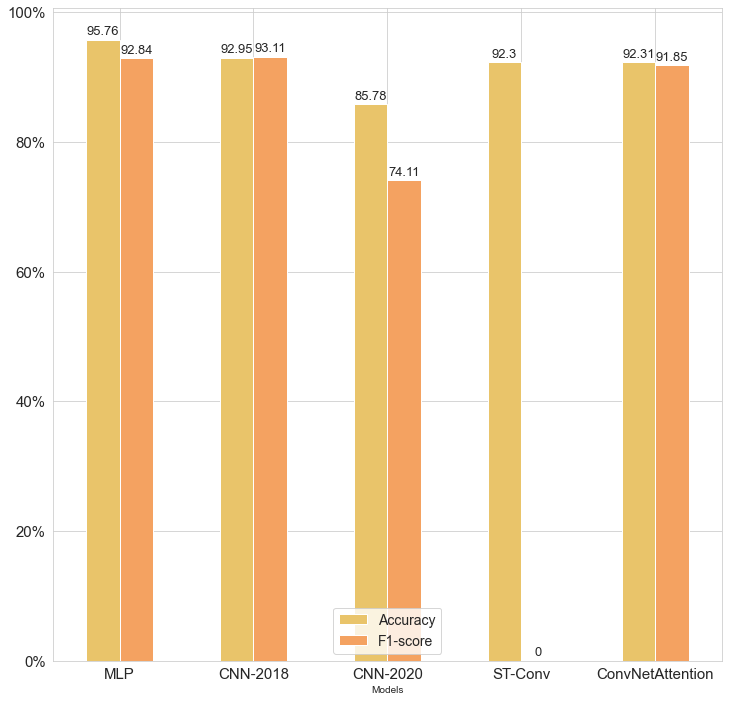

In [51]:
IMAGE_SAVE_PATH = f"C:/Users/lokix/OneDrive/Documents/univsersidad/MASTER/1B/TFM/imagenes_memoria/plots/sotacomparison_newpaper.pdf"
sns.set_style("whitegrid")
sns.color_palette("pastel")
models = ["MLP", "CNN-2018", "CNN-2020", "ST-Conv", "ConvNetAttention"]

auc = [83, 65, 93, 293, 32]
##acc = [75.2, 59.2, 84.8, 91.02]
#f1 = [75.19, 59.13, 84.61, 91.0]
#auc = [83, 65, 93, 96]
acc = [95.76, 92.95, 85.78, 92.30, 92.31]
f1 = [92.84, 93.11, 74.11, 0.0, 91.85]

data = {"Models": models, "Accuracy": acc, "F1-score": f1}#, "AUC": auc}
df = pd.DataFrame(data)
ax = df.plot(x="Models", y=["Accuracy", "F1-score"], kind="bar", rot=0, fontsize=15, figsize=(12, 12), color=["#e9c46a", "#f4a261"])#, "#e76f51"])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for container in ax.containers:
    ax.bar_label(container, size=13, padding=2, label_type='edge')
    
ax.legend(fontsize=14, loc="lower center", frameon=True)
plt.savefig(IMAGE_SAVE_PATH, transparent=True, format="pdf")

In [52]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

NameError: name 'train_dataloader' is not defined